In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
metric_names = ['Silhouette Coefficients ', 'Average Silhouette Metric ', 'Scaled Multiplied Silhouette Metric ']
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']
scale = preprocessing.MinMaxScaler()

In [3]:
# Silhouette plot 
def silhouette_plt(y_sc, silhouette_vals, numclusters, indicator):
    cluster_labels = np.unique(y_sc)
    print(y_sc)
    ax_lower, ax_upper = 0, 0
    cticks = []
    sil_plot = plt.figure()
    for i, k in enumerate(cluster_labels):
        print(k)
        c_silhouette_vals = silhouette_vals[y_sc == k]
        c_silhouette_vals.sort()
        ax_upper += len(c_silhouette_vals)
        #color = plt.jet()
        plt.barh(range(ax_lower, ax_upper), c_silhouette_vals, height=1.0, 
                         edgecolor='none', color=colors[i])
        cticks.append((ax_lower + ax_upper) / 2)
        ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 
    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    if indicator == 0:
        str2 = 'Unscaled Silhouette Plot For {} Clusters'.format(numclusters)
        #name = 'test case {}/{} cluster/og silhouette plot'.format(run, numclusters)
    else:
        str2 = 'Min-Max Silhouette Plot For {} Clusters'.format(numclusters)
        #name = 'test case {}/{} cluster/minmax silhouette plot'.format(run, numclusters)
    plt.title(str2)
    plt.tight_layout()
    # plt.show()
    # sil_plot.savefig(name)
    return silhouette_avg

In [4]:
# Find the average silhouette number per cluster
def silhouette_cluster_average(y_sc, silhouette_values, numclusters):
    silhouette_clusters = [] 
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0]
        avg_ind = sum(silhouette_values[inds])/len(inds) 
        silhouette_clusters.append(avg_ind)
    return silhouette_clusters

In [5]:
# Make the silhouette cluster average an array corresponding to the image numbers
def silhouette_cluster_array(y_sc, silhouette_clusters):
    silhouette_cluster_arr = []
    for im in range(len(y_sc)):
        cat = y_sc[im]
        c = silhouette_clusters[cat]
        silhouette_cluster_arr.append(c)
    silhouette_cluster_arr = np.array(silhouette_cluster_arr)
    return silhouette_cluster_arr

In [6]:
colors = ['#1f77b4', '#ff7f0e', '#a52a2a', '#6d1cbd', '#2ca02c'] 
radio_colors = ['#e81005', '#f7c00a', '#364acf', '#568208']

In [7]:
df1 = pd.read_csv('/Users/amalalmansour/Downloads/MaxSlice_LIDC.csv')
df2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Spiculation/Agreement_Binary_Rating.csv')
display(df2)

,noduleID,InstanceID,noduleID.1,Binary Rating,Agreement_name,Agreement,old Binary Rating,old_Binary_Rating_name,old_Agreement,old_Agreement_name,old_Two_Agreement,old_Two_Agreement_name
0,1,4,1,2,Low Radiologiests Agreement,1,2,Unknown,1,Low Radiologist Agreement,0,Low_No
1,3,134,3,2,Low Radiologiests Agreement,1,0,Not Spiculated,3,All Radiologist Agreement,1,Full_High
2,4,143,4,2,Low Radiologiests Agreement,1,2,Unknown,1,Low Radiologist Agreement,0,Low_No
3,5,118,5,0,Full Radiologiests Agreement,3,2,Unknown,1,Low Radiologist Agreement,0,Low_No
4,6,175,6,0,Full Radiologiests Agreement,3,0,Not Spiculated,3,All Radiologist Agreement,1,Full_High
...,...,...,...,...,...,...,...,...,...,...,...,...
1327,2670,6645,2670,2,Low Radiologiests Agreement,1,0,Not Spiculated,2,High Radiologist Agreement,1,Full_High
1328,2673,8814,2673,0,High Radiologiests Agreement,2,2,Unknown,1,Low Radiologist Agreement,0,Low_No
1329,2677,16479,2677,0,High Radiologiests Agreement,2,2,Unknown,0,No Radiologist Agreement,0,Low_No
1330,2688,35559,2688,0,High Radiologiests Agreement,2,2,Unknown,0,No Radiologist Agreement,0,Low_No


In [8]:
train_slices = pd.merge(df2['InstanceID'], df1)
display(train_slices)

,InstanceID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,Correlation,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,MaxProbability
0,4,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,3,3,3,...,0.894,0.0003,0.0532,8.15,1290000,0.0223,661.0,143000,541000,0.0009
1,134,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,5,4,1,...,0.899,0.0004,0.0572,8.03,735000,0.0247,416.0,111000,420000,0.0010
2,143,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,5,5,1,...,0.692,0.0027,0.0312,6.03,-469000,0.0107,420.0,98700,333000,0.0043
3,118,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,4,5,1,...,0.793,0.0018,0.0764,6.43,8600000,0.0392,565.0,137000,492000,0.0052
4,175,6,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0004\1.3.6.1....,5,1,3,5,5,1,...,0.634,0.0076,0.0296,4.98,15500000,0.0097,403.0,200000,650000,0.0105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,6645,2670,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0145\1.3.6.1....,5,1,6,5,4,1,...,0.665,0.0045,0.0327,5.52,8730000,0.0113,441.0,82700,275000,0.0074
1328,8814,2673,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0200\1.3.6.1....,3,1,6,2,5,2,...,0.432,0.0117,0.0437,4.54,8560000,0.0165,721.0,39700,112000,0.0155
1329,16479,2677,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0430\1.3.6.1....,2,1,6,5,5,1,...,0.655,0.0076,0.0298,4.98,9820000,0.0059,425.0,64500,214000,0.0098
1330,35559,2688,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0871\1.3.6.1....,4,1,6,4,5,1,...,0.550,0.0086,0.0196,4.85,20300000,0.0029,465.0,104000,322000,0.0086


In [9]:
numeric_feature_names = ['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter',
                         'MajorAxisLength', 'MinorAxisLength',
                         'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent',
                         'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity',
                         'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG',
                         'MaxIntensityBG', 'MeanIntensityBG', 'SDIntensityBG',
                         'IntensityDifference', 'markov1', 'markov2', 'markov3', 'markov4',
                         'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1',
                         'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0',
                         'gaborSD_1_0', 'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2',
                         'gaborSD_1_2', 'gabormean_2_0', 'gaborSD_2_0', 'gabormean_2_1',
                         'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 'gabormean_3_0',
                         'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2',
                         'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity',
                         'Entropy', 'x_3rdordermoment', 'Inversevariance', 'Sumaverage',
                         'Variance', 'Clustertendency']

In [10]:
df_feature = train_slices[['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter',
                         'MajorAxisLength', 'MinorAxisLength',
                         'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent',
                         'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity',
                         'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG',
                         'MaxIntensityBG', 'MeanIntensityBG', 'SDIntensityBG',
                         'IntensityDifference', 'markov1', 'markov2', 'markov3', 'markov4',
                         'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1',
                         'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0',
                         'gaborSD_1_0', 'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2',
                         'gaborSD_1_2', 'gabormean_2_0', 'gaborSD_2_0', 'gabormean_2_1',
                         'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 'gabormean_3_0',
                         'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2',
                         'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity',
                         'Entropy', 'x_3rdordermoment', 'Inversevariance', 'Sumaverage',
                         'Variance', 'Clustertendency']]

In [11]:
df_feature

,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,Eccentricity,...,Contrast,Correlation,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency
0,1094,1286,168.852814,135.372918,37.321898,42.803687,35.834900,1.194469,2.073908,0.546909,...,30300,0.894,0.0003,0.0532,8.15,1290000,0.0223,661.0,143000,541000
1,931,1062,148.267027,119.799290,34.429435,39.635819,30.844618,1.285016,1.879012,0.628016,...,22400,0.899,0.0004,0.0572,8.03,735000,0.0247,416.0,111000,420000
2,161,167,51.455844,49.201081,14.317527,18.125068,11.574663,1.565926,1.308681,0.769539,...,61400,0.692,0.0027,0.0312,6.03,-469000,0.0107,420.0,98700,333000
3,246,251,58.769553,57.721132,17.697936,18.324991,17.321312,1.057945,1.117274,0.326408,...,58900,0.793,0.0018,0.0764,6.43,8600000,0.0392,565.0,137000,492000
4,71,73,32.142136,31.494737,9.507892,10.528352,8.908660,1.181811,1.157927,0.532931,...,172000,0.634,0.0076,0.0296,4.98,15500000,0.0097,403.0,200000,650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,119,125,42.142136,41.031962,12.309163,12.708177,12.263728,1.036241,1.187617,0.262152,...,58400,0.665,0.0045,0.0327,5.52,8730000,0.0113,441.0,82700,275000
1328,44,47,26.727922,26.045905,7.484821,9.705449,6.194494,1.566786,1.292016,0.769830,...,51200,0.432,0.0117,0.0437,4.54,8560000,0.0165,721.0,39700,112000
1329,76,76,32.142136,31.963990,9.836982,10.550830,9.289905,1.135731,1.081748,0.474064,...,51600,0.655,0.0076,0.0298,4.98,9820000,0.0059,425.0,64500,214000
1330,57,61,29.556349,28.884864,8.519076,10.270827,7.463864,1.376074,1.219598,0.686949,...,105000,0.550,0.0086,0.0196,4.85,20300000,0.0029,465.0,104000,322000


In [12]:
agreements = df2['Agreement']

In [13]:
df_feature = pd.DataFrame(scale.fit_transform(df_feature.values), columns= numeric_feature_names)
df_feature = np.array(df_feature)

In [14]:
df_feature.shape

(1332, 64)

In [15]:
X_embedded = TSNE(n_components=2,random_state=2).fit_transform(df_feature)

/Users/amalalmansour/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/amalalmansour/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(array([-60., -40., -20.,   0.,  20.,  40.,  60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

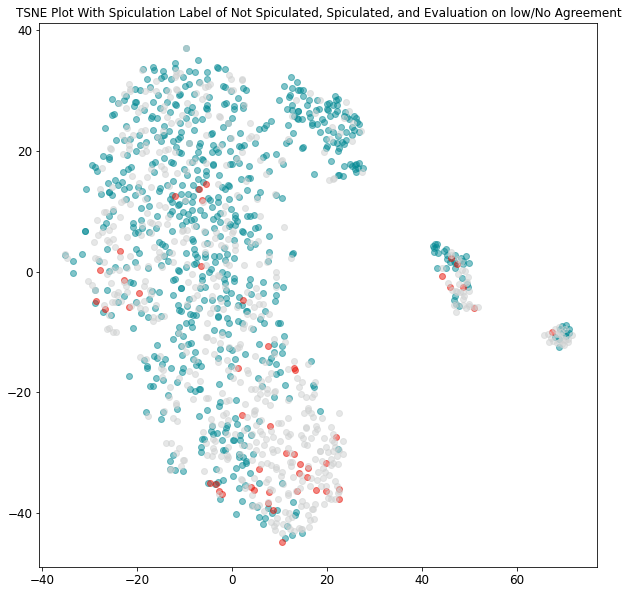

In [16]:
## Print tsne with class labels (spic/non-spic) for training and validation data 
#Binary_Rating = pd.read_csv("/Users/amalalmansour/Desktop/New_Images/Spiculation/Agreement_Binary_Rating.csv")
radio_ids = df2['InstanceID'] #pandas dataframe
radio_ids2 = radio_ids.values #list
Bin_Rating = df2['Binary Rating']

spic_tsne = plt.figure(figsize=(10,10))
spic_classes = [0,1,2]
#spic_classes = [0,1,2,3]

spic_colors = ['#048a94','#e81005','#cfd1d1']
#spic_colors = ['#048a94','#e81005','#100494','#cfd1d1'] # RED, BLUE   # 1 = Spiculated, 0 = Not Spiculated
spic_legend = ['Not Spiculated', 'Spiculated', 'Evaluation on low/No Agreement']
#spic_legend = ['Not Malignant','Malignant', 'Indeterminant','Evaluation on low/No Agreement']

agreement_inds = []
agreement_id = []

for i in spic_classes:
    inds = np.where(Bin_Rating==i)
    plt.scatter(X_embedded[inds, 0], X_embedded[inds,1], alpha=0.5, color=spic_colors[i])
plt.title('TSNE Plot With Spiculation Label of Not Spiculated, Spiculated, and Evaluation on low/No Agreement')
#plt.title('TSNE Plot With Malignancy Label of Not Malignant Malignant Indeterminant and Evaluation on low/No Agreement')                                                         # commented out title
#plt.legend(spic_legend, fontsize=10, loc=2)
'''ax = plt.gca()
leg = ax.get_legend()

leg.legendHandles[0].set_color('#048a94')
leg.legendHandles[1].set_color('#e81005')
#leg.legendHandles[2].set_color('#100494')
leg.legendHandles[2].set_color('#cfd1d1')'''

#plt.legend(handles=scatter.legend_elements()[0], labels=spic_legend, fontsize=17, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#spic_tsne.savefig(name9, bbox_inches='tight')

(array([-60., -40., -20.,   0.,  20.,  40.,  60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

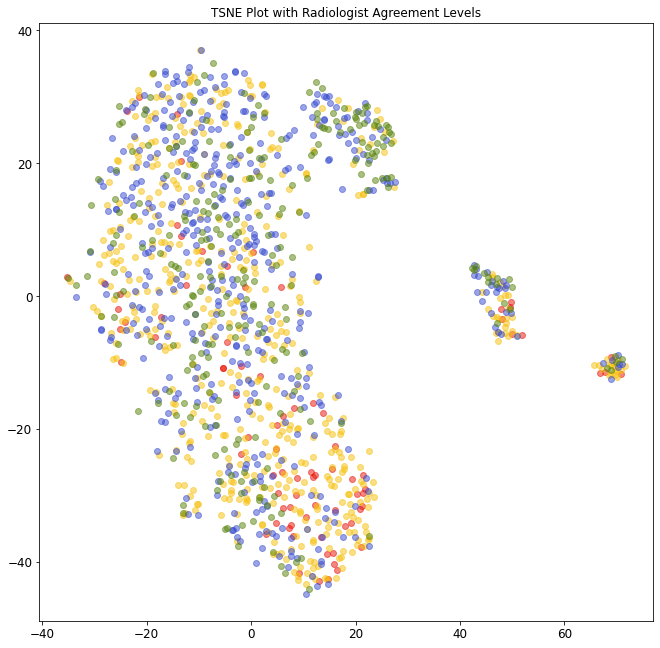

In [17]:
radio_ids = df2['InstanceID'] #pandas dataframe
radio_ids2 = radio_ids.values #list
agreements = df2['Agreement']
tsne_radio = plt.figure(figsize=(11,11))
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']

agreement_inds = []
agreement_id = []

for i in radio_classes:
    inds = np.where(agreements==i)
    plt.scatter(X_embedded[inds, 0], X_embedded[inds,1], alpha=0.5, color=radio_colors[i])
    ids = radio_ids2[inds]
    agreement_inds.append(inds)  # should be in the order of high agreement -> low agreement  # also, these are the index numbers
    agreement_id.append(ids)  # these are the instance id's
plt.title('TSNE Plot with Radiologist Agreement Levels')                                                                       # commented out title
#plt.title('(b)', fontweight="bold", fontsize=20, y=-0.1)
#plt.legend(radio_names, fontsize=10, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

{0: 376, 1: 956}


Text(0.5, 1.0, 'K-Means Clustering TSNE With 2 Clusters')

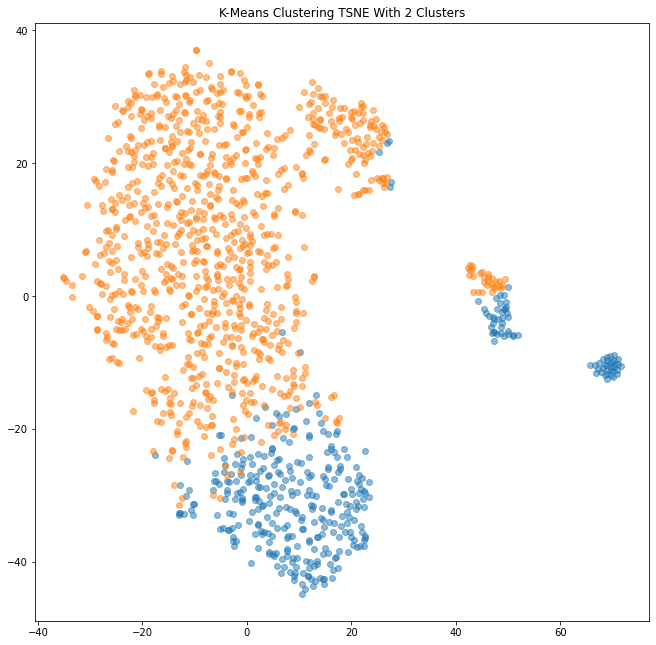

In [18]:
##### Run Kmeans clustering on the embeddings for ALL of the data ##### 
numbers = [2] #[2, 3, 4, 5, 6] #number of clusters
wss_total = []
sc = KMeans(n_clusters=numbers[0], random_state=0)
y_sc = sc.fit_predict(df_feature)
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))
og_spectral = plt.figure(figsize=(11,11))
for i in range(numbers[0]):
    inds = np.where(y_sc==i)[0]
    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
plt.title('K-Means Clustering TSNE With {} Clusters'.format(numbers[0]))

In [19]:
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))

{0: 376, 1: 956}


In [20]:
##### Run Spectral clustering on the embeddings for ALL of the data #####
'''
numbers = [2] #[2, 3, 4, 5, 6] #number of clusters
wss_total = []

sc = SpectralClustering(n_clusters=numbers[0], random_state=0) 
y_sc = sc.fit_predict(df_feature)
print(len(y_sc))
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))
og_spectral = plt.figure(figsize=(11,11))
for i in range(numbers[0]):
    inds = np.where(y_sc==i)[0]
    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
plt.title('Spectral Clustering TSNE With {} Clusters'.format(numbers[0]))
'''

"\nnumbers = [2] #[2, 3, 4, 5, 6] #number of clusters\nwss_total = []\n\nsc = SpectralClustering(n_clusters=numbers[0], random_state=0) \ny_sc = sc.fit_predict(df_feature)\nprint(len(y_sc))\n#Conunt how many instances in each cluster\nunique, counts = np.unique(y_sc, return_counts=True)\nprint(dict(zip(unique, counts)))\nog_spectral = plt.figure(figsize=(11,11))\nfor i in range(numbers[0]):\n    inds = np.where(y_sc==i)[0]\n    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])\nplt.title('Spectral Clustering TSNE With {} Clusters'.format(numbers[0]))\n"

[0 0 1 ... 1 1 0]
0
1


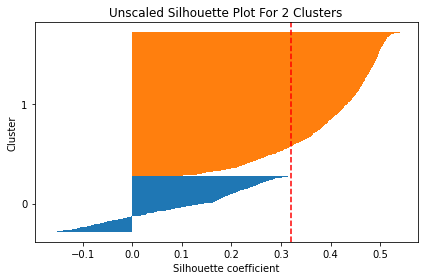

In [21]:
# First, do all silhouette work on the raw embeddings
silhouette_valsb4 = silhouette_samples(df_feature, y_sc, metric='euclidean') # get the silhouette value per sample
silhouette_avgb4 = silhouette_plt(y_sc, silhouette_valsb4, numbers[0], 0) # create and save the silhouette plot, and find the average of all of the silhouette scores
silhouette_clustersb4 = silhouette_cluster_average(y_sc, silhouette_valsb4, numbers[0])
sil_clusterb4_avg = np.mean(silhouette_clustersb4) # average all of the averaged silhouette cluster scores
stdclustersb4 = np.std(silhouette_clustersb4) # find the standard deviation of the averaged silhouette cluster scores
sil_clus_arrayb4 = silhouette_cluster_array(y_sc, silhouette_clustersb4) # make the silhouette cluster an array corresponding to the image numbers

In [22]:
len(silhouette_valsb4)

1332

In [23]:
sil_clusterb4_avg

0.2566655336551899

In [24]:
stdclustersb4

0.14678757010492605

In [25]:
silhouette_valsb4

array([0.30475534, 0.26461477, 0.37104984, ..., 0.4714657 , 0.51873616,
       0.04190968])

[0 0 1 ... 1 1 0]
0
1


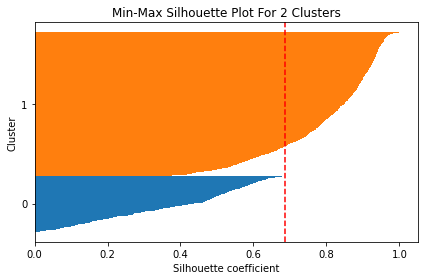

In [26]:
# Min Max all of the silhouette values, then repeat 
scaler = MinMaxScaler()
silhouette_vals = scaler.fit_transform(silhouette_valsb4.reshape(-1,1))
silhouette_vals = silhouette_vals.flatten() # normalized silhouette values
sil_avg_minmax = silhouette_plt(y_sc, silhouette_vals, numbers[0], 1)
silhouette_clusters = silhouette_cluster_average(y_sc, silhouette_vals, numbers[0]) # cluster average = sum(normalized silhouette values)/#(normalized silhouette values)
sil_cluster_avg = np.mean(silhouette_clusters)
stdclusters = np.std(silhouette_clusters)  
sil_clus_array = silhouette_cluster_array(y_sc, silhouette_clusters) # Assign cluster average for each point

In [27]:
sil_cluster_avg

0.5958592308512909

In [28]:
silhouette_clusters

[0.3868761722196249, 0.804842289482957]

In [29]:
np.unique(sil_clus_array, return_counts= True)

(array([0.38687617, 0.80484229]), array([376, 956]))

In [30]:
for num in silhouette_vals.tolist():
    # checking condition
    if num < 0:
        print(num, end=" ")

In [31]:
# Take the average of the scaled silhouette values
scaler = MinMaxScaler() 
# Multiply the scaled silhouette values
ci = 1 - (np.multiply(silhouette_vals, sil_clus_array))  ##  < to switch the metric backwards
ci_norm = scaler.fit_transform(ci.reshape(-1,1)) #< min max the confidence interval values
ci_norm = ci_norm.reshape(len(y_sc))

In [32]:
for num in ci.tolist():
    # checking condition
    if num < 0:
        print(num, end=" ")

In [33]:
ci.min()

0.195157710517043

In [34]:
ci_norm.min()

0.0

In [35]:
# Save histograms for the metrics
def save_hist(data, numclusters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(data, color="black")
    ax.set_title('Silhouette Coefficients Histogram')
    ax.set_xlabel('Silhouette Coefficients Values')
    ax.set_ylabel('Frequency')
    #ax.set_xticks(minor=False)
    fig.tight_layout()
    #fig.savefig("test case {}/{} cluster/Histogram - {}.png".format(run, numclusters, filename), format='png')
    plt.show(fig)

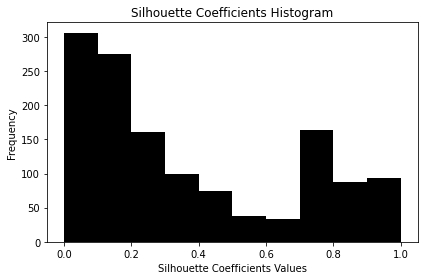

In [36]:
## Plot histograms for the metrics 
list_of_metrics = [ci_norm]
for q in range(len(list_of_metrics)):
    save_hist(list_of_metrics[q], numbers[0])

In [37]:
list_of_metrics

[array([0.68066838, 0.70813887, 0.24129059, ..., 0.09832744, 0.03102797,
        0.86054876])]

441


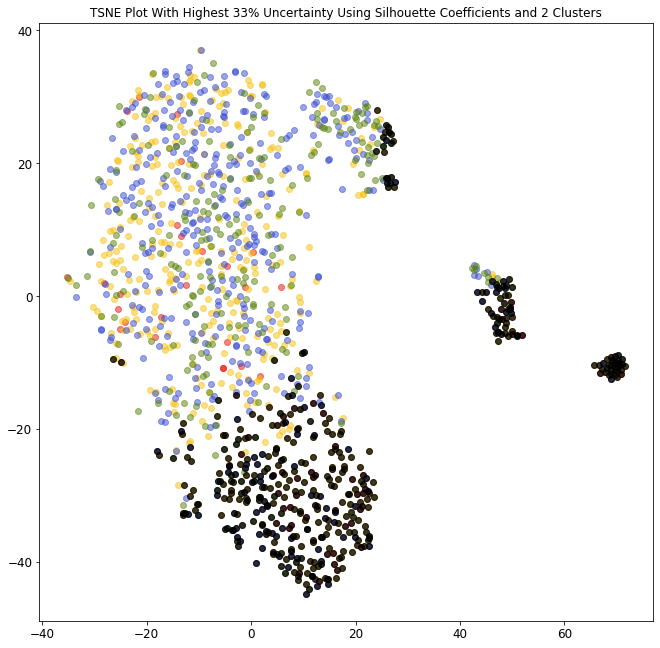

In [38]:
for m in range(len(list_of_metrics)):
    newlegend = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree', 'Metric Highest Uncertainty']
    newlistnum = [441] #33% #[353, 706] #25%, 50%
    for r in newlistnum:
        indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
        print(len(indlargest))
        new1 = plt.figure(figsize=(11,11))
        for i in radio_classes:
            inds = np.where(agreements==i)
            plt.scatter(X_embedded[inds, 0], X_embedded[inds,1], alpha=0.5, color=radio_colors[i]) 
        for k in indlargest:
            plt.scatter(X_embedded[k,0], X_embedded[k,1], alpha=0.75, color = 'black')
        title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numbers[0])
        plt.title(title2)                                                                                                                              # commented out title    
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        #plt.legend(newlegend, fontsize=10, loc=2)
        plt.show()

In [39]:
total_ids = df2['InstanceID']
spic_ids = df2['InstanceID'].tolist()
spic_tr_val = df2['Binary Rating'].tolist()
vis_tr_te = df2['Agreement'].tolist()

In [40]:
##### Highest Uncertainty Points #####
## obtain highest uncertainty indices 
unc_index = np.argpartition(ci_norm, -1332)[-1332:] 
unc_values = ci_norm[unc_index]
unc_ids = total_ids[unc_index]
unc_imgs = df_feature[unc_index]

# fix the agreement id variable to be iterable...
agreement_id2 = []
agreement_levels = []
counter = 0
for a in agreement_id:
    for k in a:
        agreement_id2.append(k)
        agreement_levels.append(counter)
    counter += 1

# retrieve vals for specific ids (highest uncertainty ids)
uncertainty_agreement = []
uncertainty_names = []

for k in unc_ids:
    agr_index = agreement_id2.index(k)
    unc_agr = agreement_levels[agr_index]
    unc_agr2= radio_names[unc_agr]

    uncertainty_agreement.append(unc_agr)
    uncertainty_names.append(unc_agr2)

######### ---Amal--- #########

## get spiculation rating for each image
spic_rate = []
instance_id = []
for j in unc_ids:
    if j in spic_ids:
        spic_index = spic_ids.index(j)
        spic_r = spic_tr_val[spic_index]
        spic_rate.append(spic_r)
        instance_id.append(j)

######### ---Amal--- #########


## print out each image
counter = 0

#To get uncertinaty scores for distrbution
num = []
agre = []
siz = []
spic = []
inst_id = []

for l in range(len(unc_imgs)):
    actual_unc = unc_values[l]
    num.append(actual_unc)
    unc_name = uncertainty_names[l]
    agre.append(unc_name)
    spic_unc = spic_rate[l]
    spic.append(spic_unc)
    id_inst = instance_id[l]
    inst_id.append(id_inst)

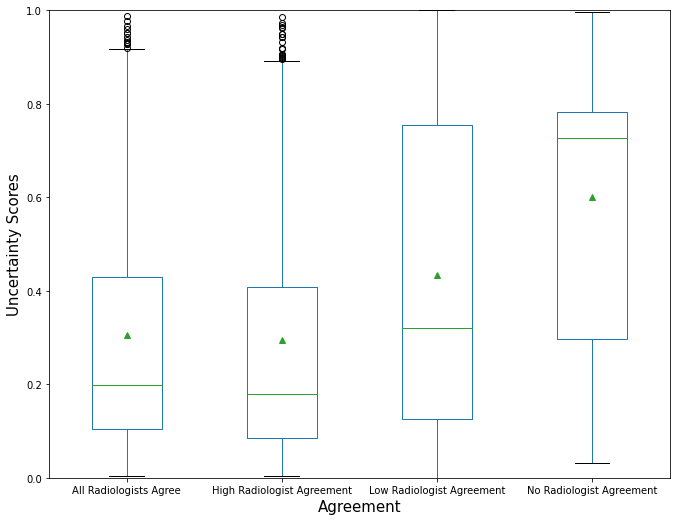

In [41]:
data = {'InstanceID': inst_id,
        'Score': num,
        'Agreement': agre,
        'Spiculation':spic}

# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
df.to_csv("/Users/amalalmansour/Desktop/New_Images/Spiculation/DF_spic_max_scores_kmeans.csv")

plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Agreement',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
plt.show()

In [42]:
len(df)

1332

In [43]:
m2 = df.groupby(['Agreement'])['Score'].mean().values
print(m2)

[0.30572863 0.29365926 0.43315432 0.59990422]


In [44]:
m1 = df.groupby(['Agreement'])['Score'].median().values
print(m1)

[0.19947081 0.1791791  0.32037142 0.72707338]


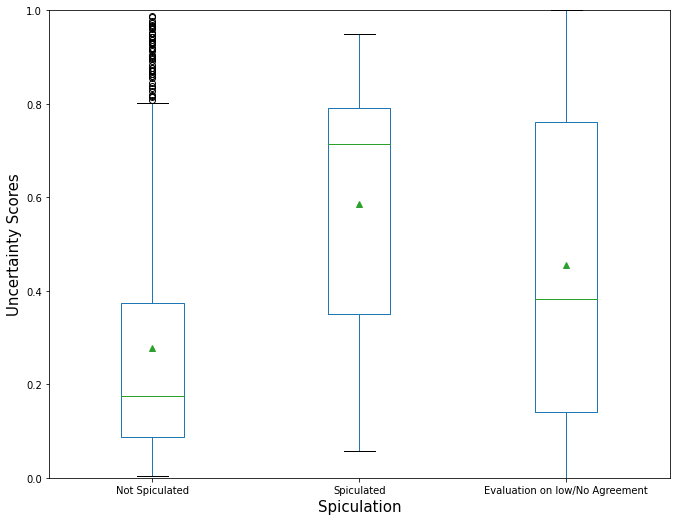

In [45]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Spiculation',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Spiculation", fontdict={'fontsize':15})
plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Evaluation on low/No Agreement'])
#plt.xticks([1, 2, 3,4], ['Not Malignant','Malignant', 'Indeterminate','Evaluation on low/No Agreement'])
plt.show()

In [46]:
m1 = df.groupby(['Spiculation'])['Score'].mean().values
print(m1)

[0.27685129 0.58641383 0.45603075]


In [47]:
m1 = df.groupby(['Spiculation'])['Score'].median().values
print(m1)

[0.17458657 0.71401925 0.38332281]


([<matplotlib.axis.XTick at 0x167f06490>,
 [Text(1, 0, 'Not Spiculated\nAll Radiologists Agree'),
  Text(2, 0, 'Not Spiculated\nHigh Radiologist Agreement'),
  Text(3, 0, 'Spiculated\nAll Radiologists Agree'),
  Text(4, 0, 'Spiculated\nHigh Radiologist Agreement'),
  Text(5, 0, 'Evaluation on low Agreement'),
  Text(6, 0, 'Evaluation on No Agreement')])

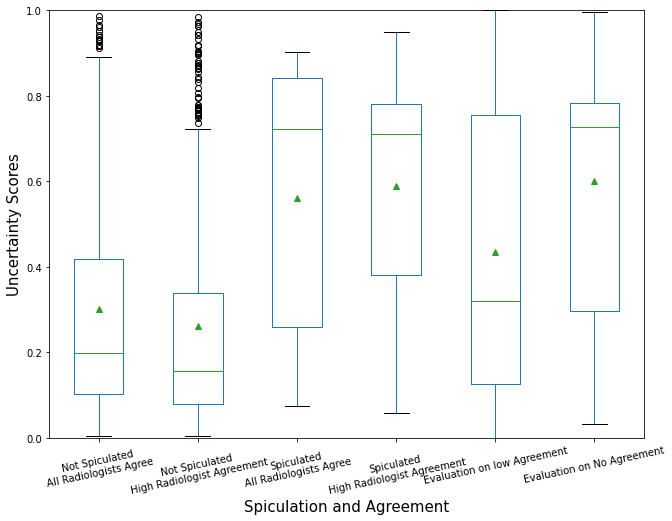

In [48]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
#newlegend1 = ['Not Malignant', 'Malignant','Indeterminant', 'Unknown']
axes = df.boxplot(by=['Spiculation','Agreement'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Spiculation and Agreement",fontdict={'fontsize':15})
plt.xticks([1, 2, 3, 4,5,6], ["Not Spiculated\nAll Radiologists Agree", "Not Spiculated\nHigh Radiologist Agreement", "Spiculated\nAll Radiologists Agree", "Spiculated\nHigh Radiologist Agreement", "Evaluation on low Agreement", "Evaluation on No Agreement"], rotation=12, fontsize=10)
#plt.xticks([1, 2, 3, 4,5,6,7,8], ["Not Malignant\nAll Radiologists Agree", "Not Malignant\nHigh Radiologist Agreement", "Malignant\nAll Radiologists Agree", "Malignant\nHigh Radiologist Agreement", "Indeterminant\nAll Radiologists Agree", "Indeterminant\nHigh Radiologist Agreement", "Low Radiologist Agreement", "No Radiologist Agreement"], rotation=22, fontsize=11)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

In [49]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].describe()
print(m1)

                                        count      mean       std       min  \
Spiculation Agreement                                                         
0           All Radiologists Agree      265.0  0.300937  0.264748  0.003785   
            High Radiologist Agreement  412.0  0.261359  0.254317  0.004080   
1           All Radiologists Agree        5.0  0.559680  0.370809  0.072957   
            High Radiologist Agreement   45.0  0.589384  0.264262  0.056548   
2           Low Radiologist Agreement   522.0  0.433154  0.325076  0.000000   
            No Radiologist Agreement     83.0  0.599904  0.292093  0.031485   

                                             25%       50%       75%       max  
Spiculation Agreement                                                           
0           All Radiologists Agree      0.102571  0.198877  0.418638  0.987032  
            High Radiologist Agreement  0.078131  0.155695  0.338341  0.985223  
1           All Radiologists Agree      0.2

In [50]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].median().values
print(m1)

[0.19887655 0.15569543 0.72279493 0.71111008 0.32037142 0.72707338]
